### Cab-Driver Agent
### Group Case Study : Reinforced Deep Learning
#### Submitted by : 
Abhishek Ranjan

Aiswarya Ramachandran

Anugraha Sinha

Vikash Sinha

### Importing Libraries

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import os
from datetime import datetime

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Tracking the state-action pairs for checking convergence

##### Comment Team :
We have taken some tactical states and actions for reference. At every tracked state we check (0,0) action and other some common action, with the assumption that the driver is at the same location as the request location. 


In [0]:
def initialize_states_track():
    states_action_pair_to_track = [((1,0,0),(1,2)),
                                   ((1,0,0),(0,0)),
                                   ((2,2,2),(2,3)),
                                   ((2,2,2),(0,0)),
                                   ((3,3,3),(3,4)),
                                   ((3,3,3),(0,0)),
                                   ((4,4,4),(4,5)),
                                   ((4,4,4),(0,0)),
                                   ((5,5,5),(5,1)),
                                   ((5,5,5),(0,0))]
    for state,action in states_action_pair_to_track:
        if state not in States_Track.keys():
            States_Track[state] = collections.defaultdict()
            States_Track[state][action] = []
        else:
            States_Track[state][action] = []

def update_states_track(driver):
    for s in States_Track.keys():
        s_encode = driver.state_encoder(s)
        q_predict = driver.model.predict(s_encode)
        for a in States_Track[s].keys():
            a_idx = list(filter(lambda x : a == driver.env.action_space[x],range(0,len(driver.env.action_space))))[0]
            q_value = q_predict[0][a_idx]
            States_Track[s][a].append(q_value)

In [0]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.
      
### Comment from team:
The DQNAgent we have made has unique factor of virtualizing 2 kinds of agents, which are signified with the "driver_psychology" variable
1. **Driver Psychology : Enthusiastic** : 
After getting the requests provided by environment (which is based on the location and the poisson distribution at the specific location), it checks the q_values using the network. This driver selects the "MAX" q_value from among the requests it has got. There requests also include (0,0) action. This enables the driver to be more "ENTHUSIASTIC" in taking up the rides.

2. **Driver Psychology : Adamant** : After getting the requests from the environment (which is based on the location and the poisson distribution at the specific location), it checks the q_values using the network. If the action concerning "MAX" q_value is among the list of requests provided by the environment, then this driver takes the action. If NOT, then it defaults to (0,0) action, that is skipping it. This driver is more "ADAMANT" in following what the Q network says. Such a virtual driver is more adamant to what he already knows and does not want to go with what is being offered by the environment.

### Q-Network Architecture for DQNAgent Class
We will be using **ARCHITECTURE 1** where in
- INPUT : Encoded States
- OUPUT : Q_Values for all actions (including (0,0) action)

### Hyper parameters for DQNAgent Class
- state_size : Vector length of encoded states (INPUT SIZE) : (36 -> 5 cities + 24 hours + 7 days)
- action_size : Vector length of q_values predicted, all actions (OUTPUT SIZE) : (21 -> (4*5) + 1  -> aka -> (m-1 * m) + 1)
- learning_rate : Learning rate used by Q-Network
- discount_factor : Discount factor used for next_state best action
- epsilon_max : Maximum epsilon value
- epsilon_min : Minimum epsilon value
- batch_size : batch_size used by NN to execute FowardPropogation/BackwardPropogation in batches.
- memory_length : memory deque size
- learn_nn_epochs : EPOCHS for learning the Q_Network in 1 iteration of complete memory


## Information for the evaluation team ##

**Driver Psychology : Enthusiastic** should be taken for evaluation. The other driver psychology is for testing and experiment purpose only. We will first showcase, **ENTHUSIASTIC** driver and check how its rewards are increasing over long term. Later on we will showcase the other driver details also.

In [0]:
n_exploration = 0
n_exploitation = 0
class DQNAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate = 0.09, 
                 discount_factor=0.95, 
                 epsilon_max=1.0,
                 epsilon_min=0.0,
                 batch_size = 32,
                 memory_length = 2000,
                 learn_nn_epochs = 1,
                 debug_msg = False,
                 driver_psychology="Adamant"):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate =  learning_rate
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory_length = memory_length
        self.learn_nn_epochs = learn_nn_epochs
        # create replay memory using deque
        self.memory = deque(maxlen=self.memory_length)
        
        # Driver's Psychology #
        self.driver_psychology = driver_psychology
        
        # environment object #
        self.env = CabDriver()
        self.env.debug = debug_msg
        
        # create main model and target model
        self.model = self.build_model()
        
        # encoder function #
        self.state_encoder = self.env.state_encod_arch1    # we use ARCHITECTURE 1 type of Q_Network #
        
        # model saving directory #
        self.model_dir = "RLModel_Driver_Arch2" + "_LR_" + str(self.learning_rate) + "_dist_" + str(self.discount_factor) +\
                    "_batch_" + str(self.batch_size) + "_memlen_" + str(self.memory_length)
        
        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Input layer
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        # Hidden Layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # Output Layer
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        self.env.debug_print("Printing MLP Model Architecture Summary")
        model.summary()
        return model

    def get_action(self,state,episode):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.0009*episode)
        
        random_value = np.random.random()
        
        self.env.debug_print("Episode = %d, Epsilon = %f, random_value = %f" %(episode,epsilon,random_value))
        
        request_idx, requests = self.env.requests(state)
        
        global n_exploitation
        global n_exploration
        
        if random_value > epsilon:
            # exploitation #
            # We use the model to predict the correct action #
            
            n_exploitation += 1
            encoded_state = self.state_encoder(state)
            predicted_q_values = self.model.predict(encoded_state)
            
            if self.driver_psychology == "Enthusiastic":
              # We will select the q_values of the "request_idx" obtained above
              # and select the maximum among them
              # This means the driver has psychology to choose the best from what is offered
              # Enthusiatic Driver #
              
              index_max_q_value = np.argmax(np.array([predicted_q_values[0][x] for x in request_idx]))
              self.env.debug_print("Exploitation : request_idx = %s, requests = %s, \npredicted_q_values = \n%s\n, index_max = %d -> (Enthusiatic Driver) GOT A ACTION AS PER DESIRE"\
                                      %(str(request_idx),str(requests),str(predicted_q_values),index_max_q_value))
              return requests[index_max_q_value]
            
            elif self.driver_psychology == "Adamant":
              # The model will predict some action as the best action, however, if that action is not in the list
              # of proposed actions, then we would choose the (0,0) action
              index_max_q_value = np.argmax(predicted_q_values)
              if index_max_q_value in request_idx:
                  self.env.debug_print("Exploitation : request_idx = %s, requests = %s, \npredicted_q_values = \n%s\n, index_max = %d -> (Admanant Driver) GOT A ACTION AS PER DESIRE"\
                                      %(str(request_idx),str(requests),str(predicted_q_values),index_max_q_value))
                  return self.env.action_space[index_max_q_value]
              else:
                  self.env.debug_print("Exploitation : request_idx = %s, requests = %s, \npredicted_q_values = \n%s\n, index_max = %d -> (Admanant Driver) DID NOT GET ACTION AS PER DESIRE"\
                                      %(str(request_idx),str(requests),str(predicted_q_values),index_max_q_value))
                  return (0,0)
            else:
              raise(Exception("Unknown driver Psychology given"))
        else:
            # exploration #
            # We randomly choose one of the action from requests proposed #
            n_exploration += 1
            random_selected_request = random.choice(requests)
            self.env.debug_print("Exploration : request_idx = %s, requests = %s, selected request/action = %s -> RANDOM SELECTION"\
                                    %(str(request_idx),str(requests),str(random_selected_request)))
            return random_selected_request
    

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state,action,reward,next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state_encoded_batch = np.zeros((self.batch_size, self.state_size))
            next_state_encoded_batch = np.zeros((self.batch_size, self.state_size))
            action_list, reward_list = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                current_state_encod = self.state_encoder(state)
                current_state_encoded_batch[i] = current_state_encod
                
                next_state_encod = self.state_encoder(next_state)
                next_state_encoded_batch[i] = next_state_encod
                
                action_list.append(action)
                reward_list.append(reward)
                
            current_state_q_values = self.model.predict(current_state_encoded_batch)
            next_state_q_values = self.model.predict(next_state_encoded_batch)
            
            for i in range(self.batch_size):
                action_idx = list(filter(lambda x : self.env.action_space[x] == action_list[i],range(0,len(self.env.action_space))))[0]
                current_state_q_values[i][action_idx] = reward_list[i] + (self.discount_factor * np.max(next_state_q_values))
            
            self.model.fit(current_state_encoded_batch,current_state_q_values,batch_size=self.batch_size,epochs=self.learn_nn_epochs,verbose=0)

    def save(self):
        f_name = self.model_dir + "/" + "Q_Network_Model_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".model"
        self.model.save_weights(f_name)

#### We initialize the States_Track 

In [5]:
States_Track = collections.defaultdict()
initialize_states_track()
States_Track

defaultdict(None,
            {(1, 0, 0): defaultdict(None, {(0, 0): [], (1, 2): []}),
             (2, 2, 2): defaultdict(None, {(0, 0): [], (2, 3): []}),
             (3, 3, 3): defaultdict(None, {(0, 0): [], (3, 4): []}),
             (4, 4, 4): defaultdict(None, {(0, 0): [], (4, 5): []}),
             (5, 5, 5): defaultdict(None, {(0, 0): [], (5, 1): []})})

## Main execution ##

**Remember** : We try Driver Psychology : Enthusiastic first.

### DQN block

In [0]:
Episodes = 10000
model_save_episode_trigger = 1000
states_track_save_episode_trigger = 1000
status_print_episode_trigger = 100

driver1 = DQNAgent(state_size=36,
                   action_size=21,
                   learning_rate=0.01,
                   discount_factor=0.85,
                   epsilon_max=1.0,
                   epsilon_min=0.0,
                   batch_size=32,
                   memory_length=2000,
                   learn_nn_epochs=3,
                   debug_msg = False,
                   driver_psychology = "Enthusiastic") ### Enthusiastic Driver ###

month_end_cost_time = 30 * 24

all_episode_rewards = []
all_episode_length = []
all_episode_run_time = []
start_time = datetime.now()

for episode in range(Episodes):
    
    # 1. Pick epsilon-greedy action from possible actions for the current state
    # 2. Evaluate your reward and next state
    # 3. Append the experience to the memory
    # 4. Train the model by calling function agent.train_model
    # 5. Keep a track of rewards, Q-values, loss
    
    current_state = driver1.env.init_get_state()
    month_end_terminal = False    
    total_run_time = 0
    total_reward = 0
    episode_length = 0
    while not month_end_terminal:
        #print("TESTING : Current State = %s" %(str(current_state)))
        current_action = driver1.get_action(current_state,episode)
        next_state, reward, cost_time = driver1.env.step(current_state,current_action)
        
        total_run_time += cost_time
        total_reward += reward
        
        if total_run_time >= month_end_cost_time:
            month_end_terminal = True
        
        driver1.append_sample(current_state,current_action,reward,next_state)
        driver1.train_model()
        
        current_state = next_state
        episode_length += 1
    
    all_episode_length.append(episode_length)
    all_episode_rewards.append(total_reward)
    all_episode_run_time.append(total_run_time)
    update_states_track(driver1)
    
    if (episode + 1) % model_save_episode_trigger == 0:
        driver1.save()
        
    if (episode + 1) % states_track_save_episode_trigger == 0:
        save_obj(States_Track,driver1.model_dir + "/" + "States_Track_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".pickle")
        
    if (episode + 1) % status_print_episode_trigger == 0:
        print("Episode : %d, Last Episode Reward = %f, Avg Monthly Reward : %f, Avg Episode Length : %f, Avg Episode Run Time : %f" %(episode+1,total_reward,np.mean(all_episode_rewards),np.mean(all_episode_length),np.mean(all_episode_run_time)))

end_time = datetime.now()
print("Total Time consumption : %d secs" %((end_time-start_time).seconds))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
Episode : 100, Last Episode Reward = 69.000000, Avg Monthly Reward : -120.640000, Avg Episode Length : 139.930000, Avg Episode Run Time : 723.770000
Episode : 200, Last Episode Reward = -171.000000, Avg Monthly Reward : -86.380000, Avg Episode Length : 138.710000, Avg Episode Run Time : 723.380000
Episode : 300, Last Episode Reward = 135.000000, Avg Monthly Reward : -31.550000, Avg Episode Length : 13

#### Conclusion from above results ####
Avg Monthly Reward was increasing which proves that **Enthusiastic** driver can maximize **LONG TERM MONTHLY REWARDS** if it follows the recommendation provided by the model from among the **poisson** distributed requests that come to the driver.



In [0]:
print("Number of exploitations : ",n_exploitation,"\nNumber of explorations : ",n_exploration)

Number of exploitations :  1225090 
Number of explorations :  206050


### Visualizing the average monthly reward (averaged after every 100 episodes) ###

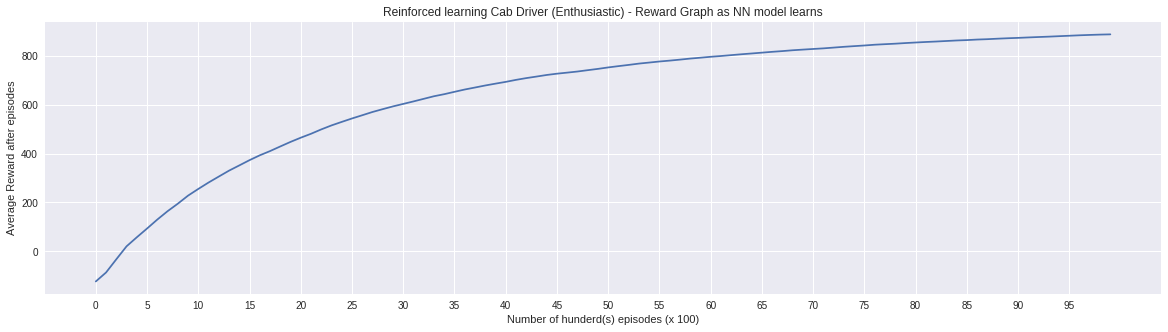

In [0]:
avg_as_model_learnt = [np.mean(all_episode_rewards[0:x+99]) for x in range(0,10000,100)]
plt.figure(figsize=(20,5))
plt.plot(range(0,len(avg_as_model_learnt)),avg_as_model_learnt)
plt.xlabel("Number of hunderd(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reinforced learning Cab Driver (Enthusiastic) - Reward Graph as NN model learns")
plt.xticks(range(0,100,5))
plt.show()

### Conclusion ###
We can see that the rewards are increasing, and as mentioned above **LONG TERM MONTHLY REWARDS** have increased to a quite an optimal value 

In [0]:
save_obj(all_episode_rewards,driver1.model_dir + "/" + "all_episode_reward.pickle")
save_obj(all_episode_length,driver1.model_dir + "/" + "all_episode_length.pickle")
save_obj(all_episode_run_time,driver1.model_dir + "/" + "all_episode_run_time.pickle")

### Tracking Convergence
Lets check which state-action pairs we can plot

In [0]:
print("State Action Pairs which can be seen for convergence:")
for s_key in States_Track.keys():
  for a_key in States_Track[s_key].keys():
    print(s_key,a_key,"Number of non 0.0 values : ",len(np.where(np.array(States_Track[s_key][a_key]) != 0.0)[0]))

State Action Pairs which can be seen for convergence:
(1, 0, 0) (1, 2) Number of non 0.0 values :  0
(1, 0, 0) (0, 0) Number of non 0.0 values :  486
(2, 2, 2) (2, 3) Number of non 0.0 values :  483
(2, 2, 2) (0, 0) Number of non 0.0 values :  486
(3, 3, 3) (3, 4) Number of non 0.0 values :  485
(3, 3, 3) (0, 0) Number of non 0.0 values :  486
(4, 4, 4) (4, 5) Number of non 0.0 values :  10483
(4, 4, 4) (0, 0) Number of non 0.0 values :  486
(5, 5, 5) (5, 1) Number of non 0.0 values :  484
(5, 5, 5) (0, 0) Number of non 0.0 values :  486


#### Plotting the state-actions where data is available ####

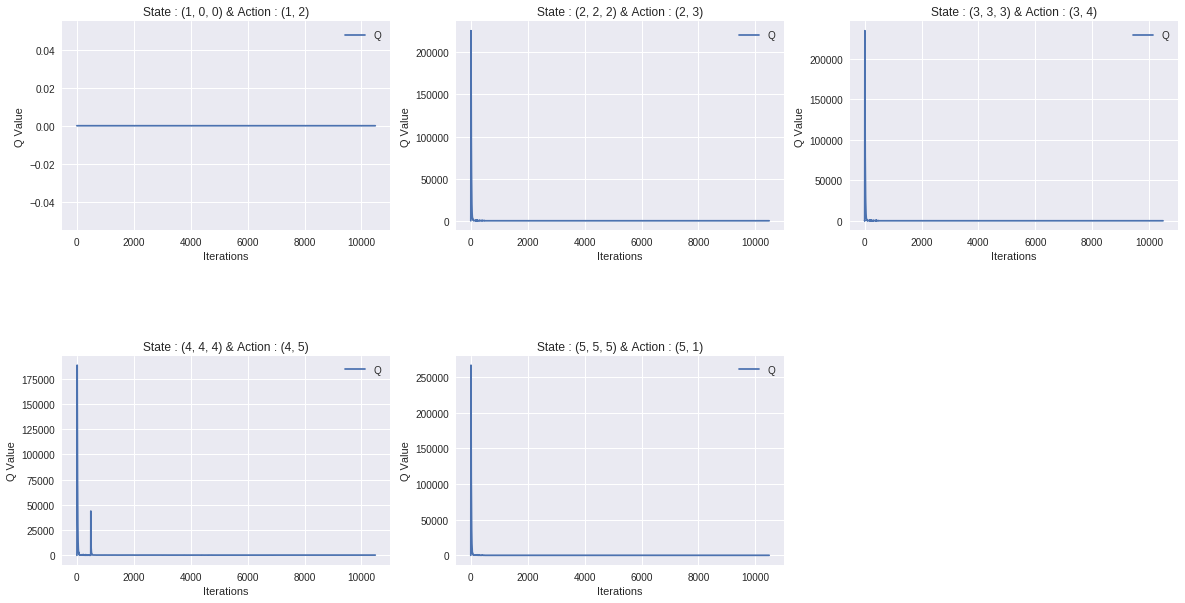

In [0]:
plt_d = [((1,0,0),(1,2)),((2,2,2),(2,3)),((3,3,3),(3,4)),((4,4,4),(4,5)),((5,5,5),(5,1))]

plt.figure(figsize=(20,10))

plt.subplot(231)
d = States_Track[plt_d[0][0]][plt_d[0][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[0][0]) + " & Action : " + str(plt_d[0][1]))
plt.legend("Q_value")

plt.subplot(232)
d = States_Track[plt_d[1][0]][plt_d[1][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[1][0]) + " & Action : " + str(plt_d[1][1]))
plt.legend("Q_value")

plt.subplot(233)
d = States_Track[plt_d[2][0]][plt_d[2][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[2][0]) + " & Action : " + str(plt_d[2][1]))
plt.legend("Q_value")

plt.subplot(234)
d = States_Track[plt_d[3][0]][plt_d[3][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[3][0]) + " & Action : " + str(plt_d[3][1]))
plt.legend("Q_value")

plt.subplot(235)
d = States_Track[plt_d[4][0]][plt_d[4][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[4][0]) + " & Action : " + str(plt_d[4][1]))
plt.legend("Q_value")

plt.subplots_adjust(hspace=0.6)
plt.show()

### Conclusion : Driver Psychology : Enthusiastic ###
Average monthly reward have increased to fairly good value. Also we can see that Q_values for selected <state - action> pairs have converged.

**Further Work**

We can change the Q-Network architecture / Learning Rate / Discount Factor to try to increase the average monthly rewards.

**We have performed some experiments for this, details are mentioned below.**

### INFORMATION FOR EVALUATION TEAM ###

### Please look for final CONCLUSION of the case study at the end of this python notebook

## Extra Experiment ##
### Main Execution ###
We now experiment with **Driver Psychology : ADAMANT**. We use all model values same as the previous, just the change in driver psychology

Note :

Refer above for understanding on Driver Psychology

In [0]:
n_exploration = 0
n_exploitation = 0

States_Track = collections.defaultdict()
initialize_states_track()
States_Track

new_model_dir = "RL_Model_Adamant_Driver_exec_1"
if not os.path.exists("./"+new_model_dir):
  os.mkdir("./"+new_model_dir)

In [0]:
Episodes = 10000
model_save_episode_trigger = 1000
states_track_save_episode_trigger = 1000
status_print_episode_trigger = 100

driver2 = DQNAgent(state_size=36,
                   action_size=21,
                   learning_rate=0.01,
                   discount_factor=0.85,
                   epsilon_max=1.0,
                   epsilon_min=0.0,
                   batch_size=32,
                   memory_length=2000,
                   learn_nn_epochs=3,
                   debug_msg = False,
                   driver_psychology = "Adamant") ### ADAMANT DRIVER ###

driver2.model_dir=new_model_dir

month_end_cost_time = 30 * 24

all_episode_rewards = []
all_episode_length = []
all_episode_run_time = []
start_time = datetime.now()

for episode in range(Episodes):
    
    # 1. Pick epsilon-greedy action from possible actions for the current state
    # 2. Evaluate your reward and next state
    # 3. Append the experience to the memory
    # 4. Train the model by calling function agent.train_model
    # 5. Keep a track of rewards, Q-values, loss
    
    current_state = driver2.env.init_get_state()
    month_end_terminal = False    
    total_run_time = 0
    total_reward = 0
    episode_length = 0
    while not month_end_terminal:
        #print("TESTING : Current State = %s" %(str(current_state)))
        current_action = driver2.get_action(current_state,episode)
        next_state, reward, cost_time = driver2.env.step(current_state,current_action)
        
        total_run_time += cost_time
        total_reward += reward
        
        if total_run_time >= month_end_cost_time:
            month_end_terminal = True
        
        driver2.append_sample(current_state,current_action,reward,next_state)
        driver2.train_model()
        
        current_state = next_state
        episode_length += 1
    
    all_episode_length.append(episode_length)
    all_episode_rewards.append(total_reward)
    all_episode_run_time.append(total_run_time)
    update_states_track(driver2)
    
    if (episode + 1) % model_save_episode_trigger == 0:
        driver2.save()
        
    if (episode + 1) % states_track_save_episode_trigger == 0:
        save_obj(States_Track,driver2.model_dir + "/" + "States_Track_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".pickle")
        
    if (episode + 1) % status_print_episode_trigger == 0:
        print("Episode : %d, Last Episode Reward = %f, Avg Monthly Reward : %f, Avg Episode Length : %f, Avg Episode Run Time : %f" %(episode+1,total_reward,np.mean(all_episode_rewards),np.mean(all_episode_length),np.mean(all_episode_run_time)))

end_time = datetime.now()
print("Total Time consumption : %d secs" %((end_time-start_time).seconds))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
Episode : 100, Last Episode Reward = -45.000000, Avg Monthly Reward : -167.020000, Avg Episode Length : 141.870000, Avg Episode Run Time : 723.650000
Episode : 200, Last Episode Reward = 99.000000, Avg Monthly Reward : -144.960000, Avg Episode Length : 144.880000, Avg Episode Run Time : 723.720000
Episode : 300, Last Episode Reward = -70.000000, Avg Monthly Reward : -125.196667, Avg Episode Length : 1

#### Checking number of exploitations and explorations

In [0]:
print("Number of exploitations : ",n_exploitation,"\nNumber of explorations : ",n_exploration)

Number of exploitations :  2094251 
Number of explorations :  207280


### Visualizing the average monthly reward (averaged after every 100 episodes) ###

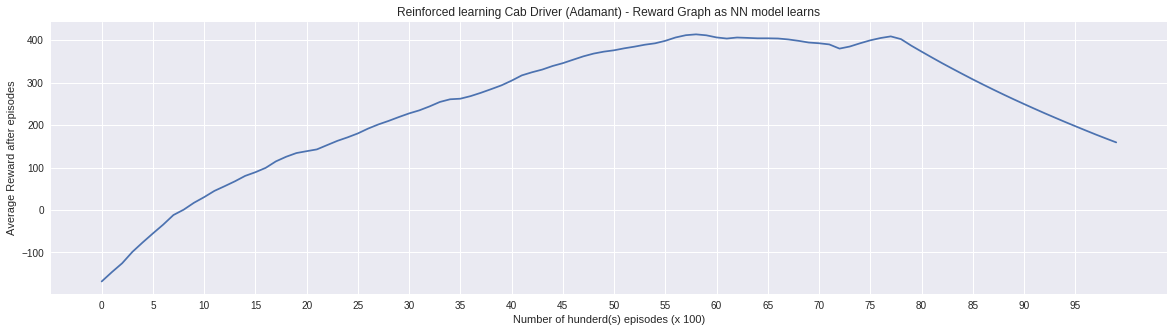

In [0]:
avg_as_model_learnt = [np.mean(all_episode_rewards[0:x+99]) for x in range(0,10000,100)]
plt.figure(figsize=(20,5))
plt.plot(range(0,len(avg_as_model_learnt)),avg_as_model_learnt)
plt.xlabel("Number of hunderd(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reinforced learning Cab Driver (Adamant) - Reward Graph as NN model learns")
plt.xticks(range(0,100,5))
plt.show()

#### Conclusion ####
We can see that with **Driver Psychology : ADAMANT**, the average monthly reward increase, and reach a maximum value after certain episodes. However, the maximum reached is **NOT as high as that of Driver Psychology : Enthusiastic**.

Therefore, if the driver is becomes **STUBBORN** and explicitly wants to select chosen rides as per earlier learning, and does not follow the best possible action from poission distributed requests, then his average monthly rewards **WONT** be very high.

In [0]:
save_obj(all_episode_rewards,driver2.model_dir + "/" + "all_episode_reward_adamant.pickle")
save_obj(all_episode_length,driver2.model_dir + "/" + "all_episode_length_adamant.pickle")
save_obj(all_episode_run_time,driver2.model_dir + "/" + "all_episode_run_time_adamant.pickle")

### Tracking Convergence
Lets check which state-action pairs we can plot

In [0]:
print("State Action Pairs which can be seen for convergence:")
for s_key in States_Track.keys():
  for a_key in States_Track[s_key].keys():
    print(s_key,a_key,"Number of non 0.0 values : ",len(np.where(np.array(States_Track[s_key][a_key]) != 0.0)[0]))

State Action Pairs which can be seen for convergence:
(1, 0, 0) (1, 2) Number of non 0.0 values :  7910
(1, 0, 0) (0, 0) Number of non 0.0 values :  7908
(2, 2, 2) (2, 3) Number of non 0.0 values :  7910
(2, 2, 2) (0, 0) Number of non 0.0 values :  7908
(3, 3, 3) (3, 4) Number of non 0.0 values :  0
(3, 3, 3) (0, 0) Number of non 0.0 values :  7908
(4, 4, 4) (4, 5) Number of non 0.0 values :  7909
(4, 4, 4) (0, 0) Number of non 0.0 values :  7908
(5, 5, 5) (5, 1) Number of non 0.0 values :  0
(5, 5, 5) (0, 0) Number of non 0.0 values :  7908


#### Plotting the state-actions where data is available ####

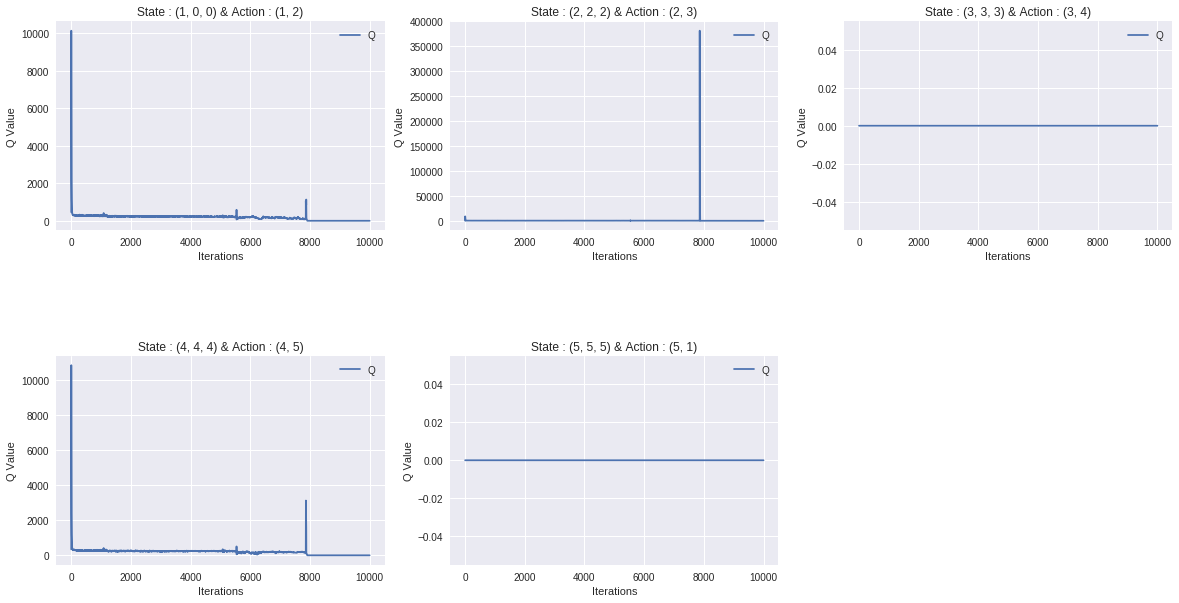

In [0]:
plt_d = [((1,0,0),(1,2)),((2,2,2),(2,3)),((3,3,3),(3,4)),((4,4,4),(4,5)),((5,5,5),(5,1))]

plt.figure(figsize=(20,10))

plt.subplot(231)
d = States_Track[plt_d[0][0]][plt_d[0][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[0][0]) + " & Action : " + str(plt_d[0][1]))
plt.legend("Q_value")

plt.subplot(232)
d = States_Track[plt_d[1][0]][plt_d[1][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[1][0]) + " & Action : " + str(plt_d[1][1]))
plt.legend("Q_value")

plt.subplot(233)
d = States_Track[plt_d[2][0]][plt_d[2][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[2][0]) + " & Action : " + str(plt_d[2][1]))
plt.legend("Q_value")

plt.subplot(234)
d = States_Track[plt_d[3][0]][plt_d[3][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[3][0]) + " & Action : " + str(plt_d[3][1]))
plt.legend("Q_value")

plt.subplot(235)
d = States_Track[plt_d[4][0]][plt_d[4][1]]
plt.plot(range(0,len(d)),d)
plt.xlabel("Iterations")
plt.ylabel("Q Value")
plt.title("State : " + str(plt_d[4][0]) + " & Action : " + str(plt_d[4][1]))
plt.legend("Q_value")

plt.subplots_adjust(hspace=0.6)
plt.show()

### Conclusion : Driver Psychology : Adamant ###
Although, the Q_values seems to be convered, however, the average monthly reward are **NOT AS HIGH AS DRIVER PSYCHOLOGY : ENTHUSIASTIC**. As stated earlier, Adamant psychology by drivers should be avoided, and best possible selection should be chosen from the actions proposed by the Q-Network model from among the poisson distributed requests coming to the driver.



### Experiments with different hyper parameters ###

| Driver Psychology | Total Episodes | Learning Rate | Discount Factor | Batch Size | Epochs | Avg Monthly Reward (@ after all episode execution | Model Learning Time (secs) | Remark |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Enthusiastic | 10000 | 0.09 | 0.85 | 128 | 3 | 221.8359 | 22976 (with GPU) | Not optimum | 
| Adamant | 10000 | 0.09 | 0.85 | 128 | 3 | -648.688 | 26676 (with GPU) | Not Optimum | 
| Enthusiastic | 10000 | 0.009 | 0.7 | 64 | 3 | 1307.1929 | 17123 (with GPU) | Good BUT Q_value convergence did not happen in 10000 episodes | 
| Adamant | 10000 | 0.009 | 0.7 | 64 | 3 | 347.663 | 17123 (with GPU) | Not Optimum | 
| Enthusiastic | 10000 | 0.009 | 0.7 | 128 | 3 | 1512.3567 | 17264 (with GPU) | Good BUT Q_value convergence did not happen for some state/action pair in 10000 episodes | 
| Adamant | 10000 | 0.009 | 0.85 | 128 | 3 | 300.3085 | 25003 (with GPU) | Not Optimum |
| Enthusiastic | 10000 | 0.005 | 0.5 | 128 | 5 | 1225.5205 | 29400 (with GPU) | Good BUT Q_value convergence did not happen for some state/action pair in 10000 episodes | 
| Adamant | 10000 | 0.005 | 0.5 | 128 | 5 | 356.74 | 41337 (with GPU) | Not Optimum |



## FINAL CONCLUSION OF CASE STUDY ##
### What we saw?###
-  There are 2 kinds of virtual drivers that we modelled.
  - **Driver Psychology "ENTHUSIASTIC"**
    - Such a driver chooses the best possible action from the requests available to him based on the q_values of "THOSE SPECIFIC" requests.
    - Such a driver is seen to have much greater monthly returns (REWARDS) and if it follows the Q-Network predicted suggestions he can have more profit over the month
    - We can also try modelling such a strategy using a different NN architecture, learning rate and discount factors for increased rewards (Work for Future)
  - **Driver Psychology "ADAMANT"**
    - Such a driver wishes to choose only those actions which he/she (his/her model) predicts to be the best. If the requests coming are not inline with his "wishes" he drops the request and prefers to go "OFFLINE".
    - Such a driver is seen to have reduced monthly returns (REWARDS) in comparison with Driver Enthusiastic.
    
### What is the learning?###
- Deep Reinforced Learning is capable of building an apt model which could suggest best possible actions for driver to maximise "LONG TERM PROFITS" as shown in the graphs above.
- By further working on the NN model architecture / learning rate / discount factors, we will be able to further maximize the monthly returns to drivers and therefore assisting them to having greater profits. Along with ensuring Q_value convergence.
- We can also see from the details mentioned above, that a DRIVER who follows the recommendation from Q-Network is able to go for longer (more profitable) trips which enhance the chances of maximizing the monthly returns.